In [ ]:
import pandas as pd
import geopandas
import random
#from shapely.strtree import STRtree
from shapely.geometry import MultiPolygon
from joblib import Parallel, delayed

In [2]:
initial_solution_df = pd.read_pickle('solutions_example.pkl')

initial_solution_df.to_csv('solutions_example.csv')

In [3]:
lsoa_geojson_path = 'https://github.com/hsma-programme/h6_3c_interactive_plots_travel/raw/main/h6_3c_interactive_plots_travel/example_code/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4.geojson'

lsoa_boundaries = geopandas.read_file(lsoa_geojson_path)

xmin, xmax = 370000, 420000
ymin, ymax = 250000, 310000

bham_region = lsoa_boundaries.cx[xmin:xmax, ymin:ymax]

bham_region["region"] = bham_region["LSOA11NM"].str[:-5]

boundary_allocations_df = pd.read_csv("boundary_allocations.csv")

bham_region = pd.merge(
    bham_region,
    boundary_allocations_df,
    left_on="region",
    right_on="Region",
    how="left"
)

bham_region["centre_dispatcher"] = bham_region["Centre"].astype("str") + '-' + bham_region["Dispatcher"].astype("str")

demand = pd.read_csv("demand_pop_bham.csv")

bham_region = bham_region.merge(demand, on="LSOA11CD")

# Create df of original boundaries
grouped_dispatcher_gdf = bham_region.groupby("centre_dispatcher")

# Create a new GeoDataFrame for the boundaries of each group
boundary_list = []

for group_name, group in grouped_dispatcher_gdf:
    # Combine the polygons in each group into one geometry
    combined_geometry = group.unary_union

    # Get the boundary of the combined geometry
    boundary = combined_geometry.boundary

    # Add the boundary geometry and the group name to the list
    boundary_list.append({'group': group_name, 'boundary': boundary})

# Create a GeoDataFrame from the list of boundaries
grouped_dispatcher_gdf_boundary = geopandas.GeoDataFrame(boundary_list, geometry='boundary', crs=bham_region.crs)


/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
def extract_allocation_df_from_solution_df(df, solution_rank, allocation_col_name, territory_col_name):
    row_of_interest = df[df['rank'] == solution_rank]
    owned_territory_dict = row_of_interest['allocations'].values[0]

    owned_territory_df = pd.DataFrame(
            [(key, value) for key, values in owned_territory_dict.items() for value in values],
            columns=[allocation_col_name, territory_col_name])
    return owned_territory_df

In [5]:
best_solution = extract_allocation_df_from_solution_df(
    initial_solution_df,
    solution_rank=1,
    allocation_col_name="centre_dispatcher_NEW",
    territory_col_name="LSOA11CD"
    )

best_solution

,centre_dispatcher_NEW,LSOA11CD
0,Centre 2-5,E01031187
1,Centre 2-5,E01031195
2,Centre 2-5,E01031217
3,Centre 2-5,E01031204
4,Centre 2-5,E01031213
...,...,...
2006,Centre 2-2,E01009724
2007,Centre 2-2,E01009720
2008,Centre 2-2,E01009723
2009,Centre 2-2,E01009725


Visualise the historical boundaries against our best solution

<Axes: >

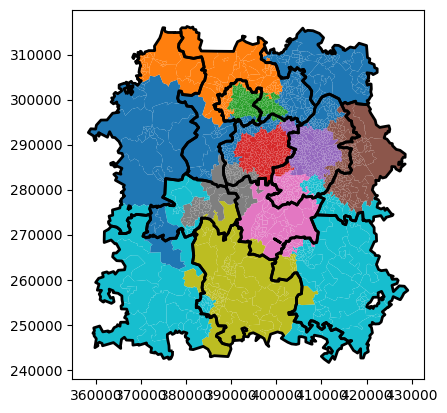

In [6]:
ax=bham_region.merge(best_solution, on="LSOA11CD").plot(column="centre_dispatcher_NEW")

# Visualise the historical boundaries
grouped_dispatcher_gdf_boundary.plot(
    ax=ax,
    linewidth=2,
    edgecolor="black"
)

In [11]:
def create_boundary_df_by_dispatcher(region_df, solution_df,
                                     region_df_merge_col, solution_df_merge_col,
                                     grouping_col):
    # Create df of original boundaries
    grouped_dispatcher_gdf_starting_solution = (
        region_df.merge(solution_df, on="LSOA11CD")
        .groupby(grouping_col)
        )

    # Create a new GeoDataFrame for the boundaries of each group
    boundary_list = []

    for group_name, group in grouped_dispatcher_gdf_starting_solution:
        # Combine the polygons in each group into one geometry
        combined_geometry = group.unary_union

        # Get the boundary of the combined geometry
        boundary = combined_geometry.boundary

        # Add the boundary geometry and the group name to the list
        boundary_list.append({'group': group_name, 'boundary': boundary})

    # Create a GeoDataFrame from the list of boundaries
    return geopandas.GeoDataFrame(boundary_list, geometry='boundary', crs=bham_region.crs)

<Axes: >

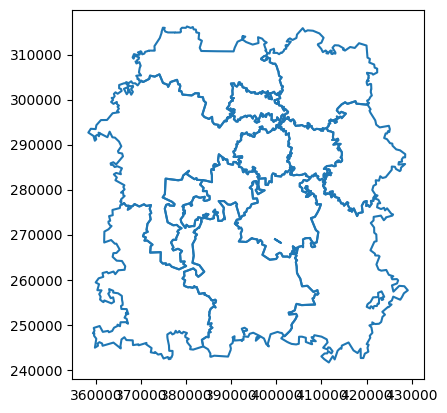

In [13]:
grouped_dispatcher_gdf_starting_solution = create_boundary_df_by_dispatcher(
    region_df=bham_region,
    solution_df=best_solution,
    region_df_merge_col="LSOA11CD",
    solution_df_merge_col="LSOA11CD",
    grouping_col="centre_dispatcher_NEW"
    )

grouped_dispatcher_gdf_starting_solution.plot()

<Axes: >

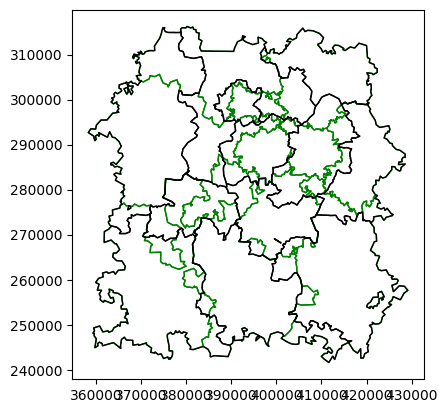

In [16]:
ax = grouped_dispatcher_gdf_starting_solution.plot(
    linewidth=1,
    edgecolor="green"
)

grouped_dispatcher_gdf_boundary.plot(
    ax=ax,
    linewidth=1,
    edgecolor="black"
)

## EA Functions

### Augmenting the dataframe with required information - used once

In [7]:
def add_neighbors_column(gdf):
    """
    Adds a column to the GeoDataFrame containing lists of indices of neighboring polygons
    based on the 'touches' method.
    """
    gdf = gdf.copy()
    neighbors = []
    for idx, geom in gdf.geometry.items():
        touching = gdf[gdf.geometry.touches(geom)]["LSOA11CD"].tolist()
        neighbors.append(touching)

    gdf["neighbors"] = neighbors
    return gdf

def find_border_dispatchers(row, df, allocation_colname='centre_dispatcher_NEW'):
    current_dispatcher = row[allocation_colname]
    neighbors = row['neighbors']

    # Get dispatchers of neighboring LSOAs
    neighboring_dispatchers = {
        df.loc[df['LSOA11CD'] == neighbor, allocation_colname].values[0]
        for neighbor in neighbors if not df[df['LSOA11CD'] == neighbor].empty
    }

    # Filter to only different dispatchers
    border_dispatchers = list(neighboring_dispatchers - {current_dispatcher})

    return border_dispatchers if border_dispatchers else []

In [53]:
def is_solution_continuous(solution_gdf, allocation_col):
    """
    Uses spatial indexing to quickly check if dispatchers have disjoint regions.
    """

    # Dissolve regions by dispatcher
    dispatcher_groups = solution_gdf.dissolve(by=allocation_col)

    for geom in dispatcher_groups.geometry:
        if isinstance(geom, MultiPolygon):
            # Check if all parts of MultiPolygon touch each other
            parts = list(geom.geoms)  # Extract individual polygons
            for i in range(len(parts)):
                if not any(parts[i].touches(parts[j]) for j in range(len(parts)) if i != j):
                    return False  # Found a fully disconnected part

    return True

def is_continuous_after_swap(solution_gdf, lsoa,
                             current_dispatcher,
                             proposed_dispatcher,
                             allocation_col):
    """
    Checks if assigning 'lsoa' to 'new_dispatcher' maintains contiguous regions.
    This version avoids making a full DataFrame copy.
    """
    # Temporarily assign new dispatcher
    solution_gdf.loc[solution_gdf["LSOA11CD"] == lsoa, allocation_col] = proposed_dispatcher

    # Check continuity
    is_valid = is_solution_continuous(solution_gdf, allocation_col)

    # Revert change immediately (avoiding full copy overhead)
    solution_gdf.loc[solution_gdf["LSOA11CD"] == lsoa, allocation_col] = current_dispatcher

    return is_valid
    #return True

def assign_new_dispatcher(row,
                          solution_gdf,
                          border_colname,
                          permutation_chance_per_border,
                          new_allocation_colname
                          ):
        """
        Attempts to assign a new dispatcher while keeping the solution continuous.
        """

        # If no bordering dispatchers, keep the original
        if not row[border_colname]:
            print(f'No borders in {row["LSOA11CD"]}')
            return row[new_allocation_colname]

        # If some bordering dispatchers, then randomly sample whether we will try to permute it
        elif random.uniform(0.0, 1.0) < permutation_chance_per_border:

            # Randomly select from border dispatchers
            current_dispatcher = row[new_allocation_colname]
            random_dispatcher = random.choice(row[border_colname])

            # Check if assigning this dispatcher keeps the solution contiguous
            if is_continuous_after_swap(solution_gdf,
                                        lsoa = row["LSOA11CD"],
                                        current_dispatcher=current_dispatcher,
                                        proposed_dispatcher=random_dispatcher,
                                        allocation_col=new_allocation_colname):
                print(f"*** Swapped {row['LSOA11CD']} to {random_dispatcher} ***")
                return random_dispatcher
            else:
                print(f":( Tried{row['LSOA11CD']} from {current_dispatcher} to {random_dispatcher}")
                return row[new_allocation_colname]  # Default to original allocation
        else:
            print(f"Not trying to permute {row['LSOA11CD']}")
            return row[new_allocation_colname]

## EA Function

In [55]:
def create_evolved_solutions(
        initial_solution_df, geodataframe,
        join_col_left, join_col_right,
        original_allocation_colname='centre_dispatcher',
        random_solution_allocation_colname='centre_dispatcher_NEW',
        new_allocation_colname='centre_dispatcher_evolved',
        border_colname='border_dispatchers',
        permutation_chance_per_border=0.2,
        population_size=1
    ):
    """
    Generates evolved dispatcher allocations while ensuring that all regions remain contiguous.
    """

    # Merge initial solution with geodataframe to keep it as a geodataframe
    initial_solution_gdf = geodataframe.merge(initial_solution_df, left_on=join_col_left, right_on=join_col_right)

    # Compute neighbors and border dispatchers
    initial_solution_gdf = add_neighbors_column(initial_solution_gdf)
    initial_solution_gdf[border_colname] = initial_solution_gdf.apply(
        find_border_dispatchers, axis=1, df=initial_solution_gdf
        )

    new_allocation_dfs = []

    # Include new_allocation_colname from the start
    simplified_allocation_df = initial_solution_gdf[[random_solution_allocation_colname, 'LSOA11CD', border_colname, "geometry"]].copy()
    simplified_allocation_df[new_allocation_colname] = simplified_allocation_df[random_solution_allocation_colname]

    for i in range(population_size):
        evolved_df = simplified_allocation_df.copy(deep=True)

        # Separate out the cols with and without borders
        non_borders_df = evolved_df[evolved_df[border_colname].apply(len) == 0]
        borders_df = evolved_df[evolved_df[border_colname].apply(len) > 0]
        if i == 0:
            print(f"{len(non_borders_df)} regions without borders and {len(borders_df)} with borders")

        borders_df[new_allocation_colname] = borders_df.apply(
            lambda row: assign_new_dispatcher(
                row, borders_df,
                border_colname,
                permutation_chance_per_border,
                new_allocation_colname
                ), axis=1)

        evolved_df = pd.concat([non_borders_df, borders_df], ignore_index=True)

        new_allocation_dfs.append(evolved_df.copy(deep=True))

        del evolved_df, non_borders_df, borders_df

    return new_allocation_dfs

## Test EA Function

### Generate one permutation

In [56]:
solution = create_evolved_solutions(
    best_solution,
    bham_region,
    join_col_left="LSOA11CD",
    join_col_right="LSOA11CD",
    population_size=1
)

solution[0]

1342 regions without borders and 669 with borders
*** Swapped E01008881 to Centre 1-7 ***
Not trying to permute E01008882
Not trying to permute E01008883
Not trying to permute E01008884
:( TriedE01008885 from Centre 1-7 to Centre 1-6
Not trying to permute E01008886
Not trying to permute E01008887
Not trying to permute E01008889
Not trying to permute E01008890
Not trying to permute E01008892
Not trying to permute E01008894
Not trying to permute E01008897
Not trying to permute E01008918
Not trying to permute E01008919
Not trying to permute E01008921
Not trying to permute E01008925
Not trying to permute E01008927
*** Swapped E01008931 to Centre 2-1 ***
Not trying to permute E01008942
Not trying to permute E01008943
:( TriedE01008946 from Centre 2-5 to Centre 2-1
*** Swapped E01008947 to Centre 2-5 ***
*** Swapped E01008949 to Centre 2-5 ***
Not trying to permute E01008952
Not trying to permute E01008953
Not trying to permute E01008955
*** Swapped E01008957 to Centre 2-5 ***
Not trying to 

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,centre_dispatcher_NEW,LSOA11CD,border_dispatchers,geometry,centre_dispatcher_evolved
0,Centre 1-7,E01008888,[],"POLYGON ((413420.692 284795.501, 413826.348 28...",Centre 1-7
1,Centre 1-7,E01008891,[],"POLYGON ((413031.049 284196.638, 413321.825 28...",Centre 1-7
2,Centre 1-7,E01008893,[],"POLYGON ((412949.766 283625.900, 412594.358 28...",Centre 1-7
3,Centre 1-7,E01008895,[],"POLYGON ((413166.349 283295.822, 413132.000 28...",Centre 1-7
4,Centre 1-6,E01008896,[],"POLYGON ((412405.000 286300.615, 412535.675 28...",Centre 1-6
...,...,...,...,...,...
2006,Centre 1-6,E01033562,"[Centre 1-5, Centre 2-1]","POLYGON ((404432.818 284070.885, 404516.073 28...",Centre 1-6
2007,Centre 1-6,E01033631,[Centre 2-1],"POLYGON ((405950.078 285312.998, 405575.210 28...",Centre 1-6
2008,Centre 2-1,E01033634,[Centre 1-6],"POLYGON ((404873.774 282636.291, 404623.886 28...",Centre 1-6
2009,Centre 1-6,E01033641,[Centre 1-7],"POLYGON ((410005.374 283902.287, 410505.181 28...",Centre 1-6


(354661.51608, 432721.98692000005, 237880.94981, 319973.24779)

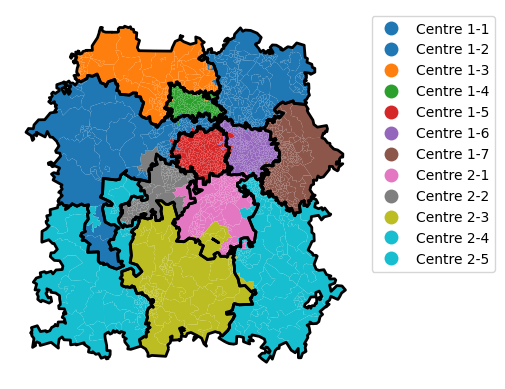

In [57]:
#| label: plot-single-solution

ax = solution[0].plot(column="centre_dispatcher_evolved", legend=True,
                      legend_kwds={'bbox_to_anchor': (1.4, 1)})

# Plot historical boundaries
grouped_dispatcher_gdf_starting_solution.plot(ax=ax, linewidth=2, edgecolor="black")

ax.axis("off")  # Hide axes for better visualization

### Generate more permutations

In [ ]:
solution = create_evolved_solutions(
    best_solution,
    bham_region,
    join_col_left="LSOA11CD",
    join_col_right="LSOA11CD",
    population_size=30
)

solution[25]

### Check solution distinctness

In [ ]:
def remove_duplicate_dataframes(df_list):
    """
    Removes duplicate dataframes from a list using hashing.

    Args:
        df_list (list of pd.DataFrame): List of pandas DataFrames.

    Returns:
        list of pd.DataFrame: List with duplicates removed.
    """
    seen_hashes = set()
    unique_dfs = []

    for df in df_list:
        df_hash = pd.util.hash_pandas_object(df[['LSOA11CD','centre_dispatcher_evolved']], index=True).values.tobytes()  # Ensure a hashable type
        if df_hash not in seen_hashes:
            seen_hashes.add(df_hash)
            unique_dfs.append(df)

    return unique_dfs

In [ ]:
print(f"There are {len(solution)} solutions generated")

print(f"There are {len(remove_duplicate_dataframes(solution))} unique solutions generated")

## Plot solutions

Plot one solution

## Evaluating solution

Now let's evaluate our evolved solutions.

### Evaluation functions from previous chapter

In [ ]:
def evaluate_solution(gdf, allocation_column='centre_dispatcher_NEW',
                      demand_column="demand"):
    grouped_by_dispatcher = gdf.groupby(allocation_column)[[demand_column]].sum()
    mean_demand = grouped_by_dispatcher['demand'].mean()

    grouped_by_dispatcher['difference_from_mean'] = (grouped_by_dispatcher['demand'] - mean_demand).astype('int')

    return abs(grouped_by_dispatcher['difference_from_mean']).mean().round(1)

def evaluate_solution_dict(solution_dict, gdf,
                            allocation_column='centre_dispatcher',
                            demand_column="demand", territory_unit_column="LSOA11CD"):

    owned_territory_df = pd.DataFrame(
            [(key, value) for key, values in solution_dict.items() for value in values],
            columns=[f"{allocation_column}_NEW", territory_unit_column])
    gdf = pd.merge(gdf, owned_territory_df, on=territory_unit_column, how="left")

    grouped_by_dispatcher = gdf.groupby(f"{allocation_column}_NEW")[[demand_column]].sum()
    mean_demand = grouped_by_dispatcher['demand'].mean()

    grouped_by_dispatcher['difference_from_mean'] = (grouped_by_dispatcher['demand'] - mean_demand).astype('int')

    return abs(grouped_by_dispatcher['difference_from_mean']).mean().round(1)